## 4. Data Preparation

### Import the necessary packages

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Import the CSV data as Pandas DataFrame

In [2]:
df = pd.read_csv('data/EasyVisa.csv')
df.shape

(25480, 12)

### Show the first 5 records of the dataset

In [3]:
df.head().T

,0,1,2,3,4
case_id,EZYV01,EZYV02,EZYV03,EZYV04,EZYV05
continent,Asia,Asia,Asia,Asia,Africa
education_of_employee,High School,Master's,Bachelor's,Bachelor's,Master's
has_job_experience,N,Y,N,N,Y
requires_job_training,N,N,Y,N,N
no_of_employees,14513,2412,44444,98,1082
yr_of_estab,2007,2002,2008,1897,2005
region_of_employment,West,Northeast,West,West,South
prevailing_wage,592.2029,83425.65,122996.86,83434.03,149907.39
unit_of_wage,Hour,Year,Year,Year,Year


### Remove data inconsistencies

In [4]:
# Drop records with prevailing wage below US federal minimum
df = df[df['prevailing_wage'] >= 7.25]
df.shape

(25469, 12)

In [5]:
# Drop records with negative number of employees
df = df[df['no_of_employees'] > 0]
df.shape

(25436, 12)

### Drop `case_id` column from the dataset

In [6]:
# Remove the column
del df['case_id']
df.shape

(25436, 11)

### Encode target variable for classification

In [7]:
df.case_status.head()

0       Denied
1    Certified
2       Denied
3       Denied
4    Certified
Name: case_status, dtype: object

In [8]:
# Replace Certified/Denied with a number: 1 (Cerified) or 0 (Denied)
df.case_status = (df.case_status == 'Certified').astype(int)
df.case_status[:5]

0    0
1    1
2    0
3    0
4    1
Name: case_status, dtype: int32

### Set up the validation framework

#### Prepare the $X$ feature matrix and the $y$ target variable

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Perform the train, validation, test split with Scikit-Learn
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.case_status.values
y_val = df_val.case_status.values
y_test = df_test.case_status.values

del df_train['case_status']
del df_val['case_status']
del df_test['case_status']

In [11]:
df_train.shape, df_val.shape, df_test.shape

((15261, 10), (5087, 10), (5088, 10))

In [12]:
df_train.head().T

,0,1,2,3,4
continent,Asia,Asia,Asia,Asia,Asia
education_of_employee,Bachelor's,Bachelor's,Master's,Bachelor's,Master's
has_job_experience,N,N,N,Y,N
requires_job_training,N,N,N,N,N
no_of_employees,2500,1527,5380,3035,546
yr_of_estab,1971,2013,1998,1907,2014
region_of_employment,Northeast,South,West,West,South
prevailing_wage,105.87,38764.07,37037.67,89891.32,149133.36
unit_of_wage,Hour,Year,Year,Year,Year
full_time_position,Y,Y,Y,N,Y


In [13]:
y_train[:5]

array([1, 0, 0, 1, 1])

In [14]:
print("Percentage of classes in training set:")
print(pd.DataFrame(y_train, columns=['case_status']).value_counts(normalize=True).round(4) * 100)

print("Percentage of classes in validation set:")
print(pd.DataFrame(y_val, columns=['case_status']).value_counts(normalize=True).round(4) * 100)

Percentage of classes in training set:
case_status
1              67.07
0              32.93
Name: proportion, dtype: float64
Percentage of classes in validation set:
case_status
1              66.58
0              33.42
Name: proportion, dtype: float64


In [15]:
numerical = df_train.select_dtypes(exclude="object").columns
categorical = df_train.select_dtypes(include="object").columns

In [16]:
numerical

Index(['no_of_employees', 'yr_of_estab', 'prevailing_wage'], dtype='object')

In [17]:
categorical

Index(['continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'region_of_employment', 'unit_of_wage',
       'full_time_position'],
      dtype='object')

### Feature Importance Analysis

This step aims to determine the most influential factors in predicting the visa application outcome.

#### Certify Rate and Risk Ratio
These metrics help assess the association between categorical features and the target variable:
- **Certify Rate:** 
  * Calculated as the proportion of certified cases within a specific category of a feature. 
  * A higher certify rate (diff $> 0$) within a category suggests a greater likelihood of certification for that category.
  * The difference between a category's certify rate and the overall certification rate provides an indication of the category's association with the target variable. 
  * Larger differences generally signify stronger associations.
- **Risk Ratio:** 
  * Calculated as the ratio of the probability of certification within a specific category to the overall probability of certification.
  * A risk ratio greater than 1 indicates that the category is more likely to be certified compared to the overall average. 
  * A risk ratio less than 1 indicates a lower likelihood of certification for that category. 
  * Risk ratios provide a relative measure of the association between a category and the target variable.

In [18]:
# Calculate the certify rate of the entire full train dataset
global_certify_rate = df_full_train.case_status.mean()
round(global_certify_rate, 2)

0.67

In [19]:
from IPython.display import display

In [20]:
# Calculate the difference and risk for all categorical variables
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).case_status.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_certify_rate
    df_group['risk'] = df_group['mean'] / global_certify_rate
    display(df_group)
    print()
    print()

continent


,mean,count,diff,risk
continent,,,,
Africa,0.704225,426,0.034774,1.051944
Asia,0.655190,13506,-0.014261,0.978697
Europe,0.792256,2970,0.122804,1.183440
North America,0.624667,2627,-0.044785,0.933103
Oceania,0.640000,150,-0.029452,0.956006
South America,0.572496,669,-0.096955,0.855172




education_of_employee


,mean,count,diff,risk
education_of_employee,,,,
Bachelor's,0.624189,8169,-0.045263,0.932389
Doctorate,0.867435,1735,0.197984,1.295740
High School,0.343601,2727,-0.325851,0.513258
Master's,0.788001,7717,0.118549,1.177084




has_job_experience


,mean,count,diff,risk
has_job_experience,,,,
N,0.562215,8559,-0.107236,0.839815
Y,0.747307,11789,0.077855,1.116297




requires_job_training


,mean,count,diff,risk
requires_job_training,,,,
N,0.667928,17966,-0.001523,0.997725
Y,0.680940,2382,0.011489,1.017162




region_of_employment


,mean,count,diff,risk
region_of_employment,,,,
Island,0.590759,303,-0.078692,0.882452
Midwest,0.759977,3458,0.090525,1.135223
Northeast,0.635173,5726,-0.034279,0.948796
South,0.702804,5599,0.033353,1.049821
West,0.616306,5262,-0.053146,0.920613




unit_of_wage


,mean,count,diff,risk
unit_of_wage,,,,
Hour,0.344425,1713,-0.325027,0.514488
Month,0.557143,70,-0.112309,0.832238
Week,0.625000,216,-0.044452,0.933600
Year,0.700747,18349,0.031295,1.046747




full_time_position


,mean,count,diff,risk
full_time_position,,,,
N,0.691667,2160,0.022215,1.033184
Y,0.666813,18188,-0.002638,0.996059


#### Mutual Information 
Mutual Information (MI) measures the amount of information one variable provides about another. 

We will rank the features based on their MI scores. The feature with the highest MI score is considered the most important, followed by the feature with the second-highest score, and so on. 

In [21]:
from sklearn.metrics import mutual_info_score

In [22]:
def mutual_info_certify_score(series):
    return mutual_info_score(series, df_full_train.case_status)

In [23]:
# Calculate mutual information scores of all categorical variables
mi = df_full_train[categorical].apply(mutual_info_certify_score)
# Sort the result such that the most important features come first
mi.sort_values(ascending=False)

education_of_employee    0.053302
unit_of_wage             0.020692
has_job_experience       0.018769
continent                0.007012
region_of_employment     0.006578
full_time_position       0.000134
requires_job_training    0.000040
dtype: float64

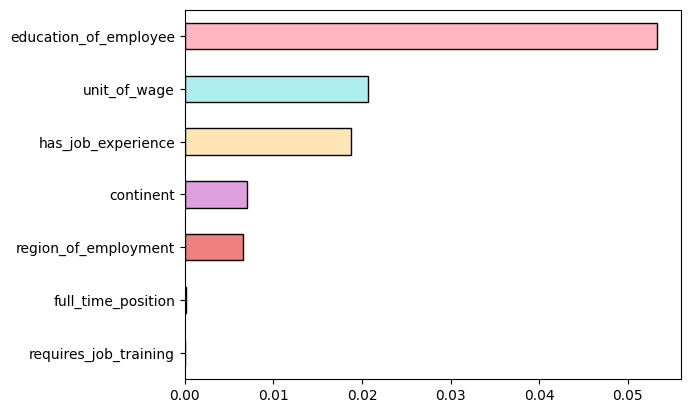

In [24]:
# Plot the bar graph
mi.nlargest(20).plot(kind='barh', ec='black', color=['lightpink', 'paleturquoise', 'moccasin', 'plum', 'lightcoral', 'sandybrown']).invert_yaxis()

**Top 5 Features:** 
* Based on Mutual Information (MI) scores, the top 5 categorical features for inclusion in the model are:
    1. `education_of_employee` (MI: 0.052196)
    2. `unit_of_wage` (MI: 0.020227)
    3. `has_job_experience` (MI: 0.017954)
    4. `continent` (MI: 0.007389)
    5. `region_of_employment` (MI: 0.006231)

**Feature Exclusion:**
* `full_time_position` has a very low MI score (0.000091), suggesting limited predictive power. Consider excluding it from the model.
* The MI score for `requires_job_training` (0.000004) is extremely low, confirming our earlier finding of no significant association with the target variable using the Chi-Square Test of Independence. This feature will be excluded from the model.

#### Correlation Coefficient

The Pearson correlation coefficient measures the linear relationship between two continuous variables. It can be used to assess the strength and direction of the linear relationship between numerical features and the binary target variable.

In [25]:
df_full_train[numerical].corrwith(df_full_train.case_status)

no_of_employees    0.010961
yr_of_estab        0.008774
prevailing_wage    0.078885
dtype: float64

Based on the correlation coefficient score of 0.075117 for `prevailing_wage`, we can infer a weak positive correlation between prevailing wage and the likelihood of visa certification by the OFLC.

In [26]:
# Rank the importance of each numerical features
corr_scores_abs = df_full_train[numerical].corrwith(df_full_train.case_status).abs().sort_values(ascending=False)
corr_scores_abs

prevailing_wage    0.078885
no_of_employees    0.010961
yr_of_estab        0.008774
dtype: float64

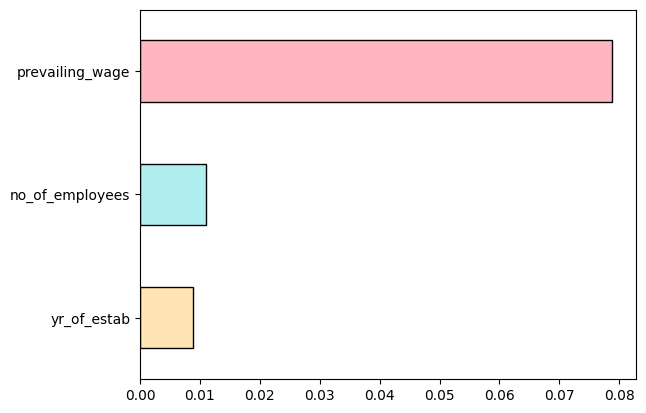

In [27]:
# Plot the bar graph
corr_scores_abs.nlargest(20).plot(kind='barh', ec='black', color=['lightpink', 'paleturquoise', 'moccasin']).invert_yaxis()

**Observation:** `prevailing_wage` emerged as the most important numerical feature, followed by `yr_of_estab` and then `no_of_employees` in predicting visa application approval. 

### Baseline Model

In [28]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [29]:
numerical

Index(['no_of_employees', 'yr_of_estab', 'prevailing_wage'], dtype='object')

In [30]:
categorical

Index(['continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'region_of_employment', 'unit_of_wage',
       'full_time_position'],
      dtype='object')

In [31]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[list(categorical) + list(numerical)].to_dict(orient='records')
X_train_baseline = dv.fit_transform(train_dict)

val_dict = df_val[list(categorical) + list(numerical)].to_dict(orient='records')
X_val_baseline = dv.transform(val_dict)

model = LogisticRegression()
model.fit(X_train_baseline, y_train)

y_pred = model.predict_proba(X_val_baseline)[:, 1]
approval_outcome = (y_pred >= 0.5)
(y_val == approval_outcome).mean()

0.7328484371928445

Our baseline logistic regression model achieved an accuracy of 73.3%.

In [32]:
thresholds = np.linspace(0, 1, 21)
scores = []

for t in thresholds:
    approval_outcome = (y_pred >= t)
    score = (y_val == approval_outcome).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.666
0.05 0.666
0.10 0.668
0.15 0.672
0.20 0.686
0.25 0.689
0.30 0.694
0.35 0.703
0.40 0.711
0.45 0.725
0.50 0.733
0.55 0.737
0.60 0.731
0.65 0.695
0.70 0.664
0.75 0.657
0.80 0.594
0.85 0.507
0.90 0.438
0.95 0.340
1.00 0.334


Text(0.5, 0, 'Threshold')

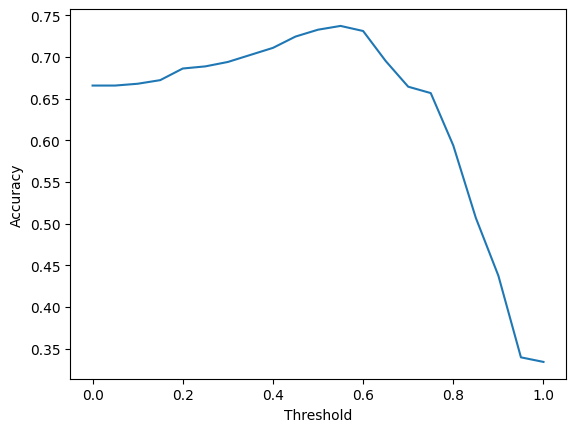

In [33]:
# Create a plot that shows how accuracy changes depending on the threshold
plt.plot(thresholds, scores)
plt.ylabel('Accuracy')
plt.xlabel('Threshold')

In [34]:
approval_outcome = (y_pred >= 0.56)
score = (y_val == approval_outcome).mean()
score

0.7379595046196187

Through experimentation with various thresholds between 0 and 1, we determined that a threshold of 0.56 yielded the highest accuracy (73.8%) for our logistic regression model on this specific dataset.

### Dummy Model

In [35]:
from collections import Counter

In [36]:
len(y_val)

5087

In [37]:
# Count # of Certified & Denied values in validation set
Counter(y_val)

Counter({1: 3387, 0: 1700})

In [38]:
y_val.mean()

0.6658148220955377

In [39]:
1 - y_val.mean()

0.33418517790446234

**Observations:**
* The baseline logistic regression model achieved an accuracy of 73.3%, which is only a slight improvement (6%) over a simple dummy model that always predicts "Certified." 
* This limited improvement suggests that the model may not be effectively capturing the underlying patterns in the data.

**Class Imbalance:**
* The dataset exhibits class imbalance, with approximately 67% of applications certified and 33% denied. 
* In such scenarios, accuracy can be a misleading metric. A model that simply predicts the majority class (in this case, "Certified") will achieve high accuracy without necessarily capturing meaningful relationships within the data.

### Baseline Model Evaluation Metrics

In [40]:
# Split the target variable y in validation set into certified and denied
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [41]:
# Split the predictions on validation set into certified and denied
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [42]:
# Combine prediction and actual into one and count how many of them
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

#### Confusion Matrix

In [43]:
# Create a confusion matrix
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[ 739,  961],
       [ 398, 2989]])

Now we know what kind of errors the model makes. We have more false positives than false negatives.

Two different types of errors, with false positives being more difficult to catch. 

In [44]:
# Instead of absolute numbers, we can have percentages
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.15, 0.19],
       [0.08, 0.59]])

**Model Misclassifications:**
- **False Positives:** The model predicts that an application will be certified, but it should be denied.
  - This can result in unqualified individuals filling positions that could be filled by qualified U.S. citizens, potentially leading to job displacement.
- **False Negatives:** The model predicts that an application will be denied, but it should be certified.
  - This can lead to the rejection of qualified and skilled foreign workers, potentially hindering economic growth and depriving the U.S. of valuable human resources.

**Importance of Minimizing Misclassifications:**

Both types of misclassifications have significant consequences.
- **False Positives:** Can lead to unfair competition for U.S. workers and potential security concerns.
- **False Negatives:** Can result in the loss of skilled labor and hinder economic growth.

**Addressing Misclassifications:**
- The F1 score is a valuable metric for evaluating the model's performance, as it considers both precision (minimizing false positives) and recall (minimizing false negatives).
- Higher F1 scores generally indicate better model performance in minimizing both types of misclassifications.

#### Accuracy

In [45]:
# Calculate accuracy
acc = (tp + tn) / (tp + tn + fp + fn)
acc

0.7328484371928445

#### Precision

In [46]:
# Calculate precision
p = tp / (tp + fp)
p

0.7567088607594936

In [47]:
1 - p

0.24329113924050638

Approximately 24% of the model's predictions are false positives, meaning the model incorrectly predicts that an application should be certified when it should actually be denied.

#### Recall

In [48]:
# Calculate recall
r = tp / (tp + fn)
r

0.8824918807204015

In [49]:
1 - r

0.11750811927959848

Our model failed to identify approximately 12% of applications that should have been certified (false negative rate of 12%).

While an overall accuracy of 73.3% might seem decent, it can be misleading due to class imbalance. A closer look at precision and recall reveals that our model exhibits strong performance in identifying true positives.

#### F1 score

In [50]:
# Calculate f1 score
f1_score = 2 * p * r / (p + r)
f1_score

0.8147744309663351

With an F1-score of 0.81, the model demonstrates excellent performance. This high score reflects a strong balance between precision and recall, effectively identifying true positives while minimizing both false positives and false negatives. This indicates a highly accurate and reliable model for predicting visa application outcomes. 

#### ROC curve

In [51]:
from sklearn.metrics import roc_curve

In [52]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

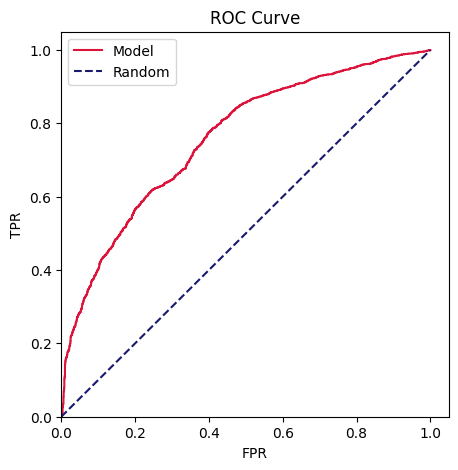

In [53]:
# Plot the ROC curve
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model', color='crimson')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--', color='midnightblue')
plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0)

plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
plt.show()

The Receiver Operating Characteristic (ROC) curve visualizes how a model's performance changes as the classification threshold varies. At very high thresholds, all models tend to predict "Denied," leading to low True Positive Rates (TPR) and low False Positive Rates (FPR).

Good models exhibit a steep initial increase in TPR with minimal increase in FPR as the threshold decreases. This indicates a strong ability to correctly classify true positives while minimizing false positives. The ROC curve of a good model typically ascends sharply towards the top-left corner of the plot.

On the other hand, poor models demonstrate a rapid increase in FPR alongside TPR, indicating a higher rate of false positive predictions. The ROC curve of a poor model tends to have a shallower slope and may curve towards the right sooner.

#### AUROC

In [54]:
from sklearn.metrics import roc_auc_score

In [55]:
# Calculate AUROC
auroc = roc_auc_score(y_val, y_pred)
auroc

0.7578002396707133

The baseline model exhibits an AUROC of 0.7578. While this score is moderate, it suggests that the model may have limited ability to effectively differentiate between positive and negative instances.

#### PR curve

In [56]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [57]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

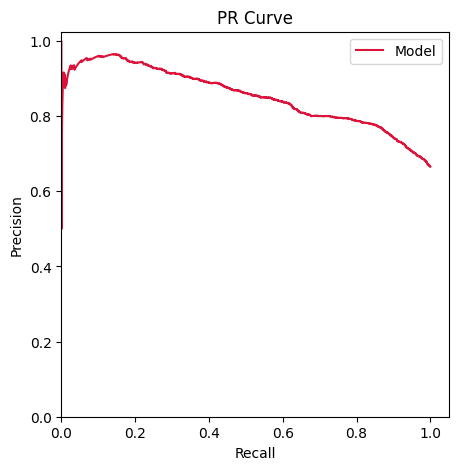

In [58]:
# Plot the PR curve
plt.figure(figsize=(5, 5))

plt.plot(recall, precision, label='Model', color='crimson')
plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0)

plt.title('PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

A Precision-Recall (PR) curve illustrates the trade-off between precision and recall for our baseline logistic regression model across different classification thresholds.

#### AUPRC

In [59]:
# Calculate AUPRC
auprc = average_precision_score(y_val, y_pred)
auprc

0.8539331481681338

Unlike accuracy, which can be misleading in imbalanced datasets, the Area Under the Precision-Recall Curve (AUPRC) provides a more robust evaluation by focusing on the model's performance in identifying the positive class (certified visa applications), even when this class is rare. 

AUPRC directly incorporates both precision and recall, two crucial metrics that assess the model's ability to accurately identify true positives while minimizing false positives and false negatives. 

An AUPRC of 0.8539 indicates strong overall performance in identifying and classifying certified visa applications, suggesting a well-balanced model that effectively minimizes both false positives and false negatives.

In [60]:
# Calculate the fraction of positives: positive examples / total number of examples
auprc_baseline = dict(Counter(y_val))[1] / len(y_val)
auprc_baseline

0.6658148220955377

The baseline AUPRC for a class is equal to the proportion of positive examples in the dataset. In this case, with 66.58% positive examples, the baseline AUPRC is 0.6658.

Achieving an AUPRC of 0.8539 significantly surpasses the baseline, indicating strong performance in identifying true positives (certified visa applications).

The higher AUPRC compared to the AUROC score (0.7578) suggests that the baseline logistic regression model is particularly effective at identifying true positives while minimizing false positives. This is crucial in the visa approval prediction context, where minimizing false positives (incorrectly certifying applications) is of paramount importance.

#### Recursive Feature Elimination

In [61]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [62]:
cv = StratifiedKFold(10)

# Create an RFE object with cross-validation and F1-score as scoring metric
rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='f1') 

# Fit RFE to the training data
rfecv.fit(X_train_baseline, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 5


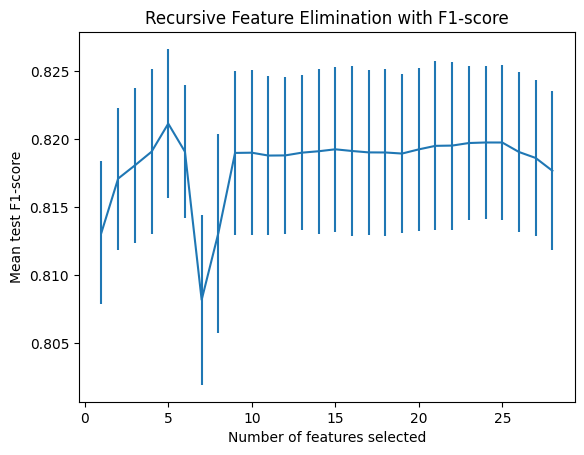

In [63]:
# Visualize the results
cv_results = pd.DataFrame(rfecv.cv_results_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test F1-score")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination with F1-score")
plt.show()

In [64]:
# Retrieve feature names
feature_names = list(dv.get_feature_names_out())

# Get feature rankings
feature_rankings = rfecv.ranking_ 

# Create a DataFrame sorted by rank
feature_importance_df = pd.DataFrame({'Feature': feature_names, 
                                      'Rank': feature_rankings}).sort_values(by='Rank').reset_index(drop=True)

# Show the feature rankings
feature_importance_df

,Feature,Rank
0,unit_of_wage=Hour,1
1,has_job_experience=N,1
2,education_of_employee=Master's,1
3,education_of_employee=Doctorate,1
4,education_of_employee=High School,1
5,continent=Europe,2
6,region_of_employment=Midwest,3
7,region_of_employment=South,4
8,unit_of_wage=Year,5
9,has_job_experience=Y,6


We performed a preliminary feature importance analysis using Recursive Feature Elimination with cross-validation (RFECV) on a baseline logistic regression model. The RFECV ranking revealed several key insights.

**Key Findings:**
- Features such as `unit_of_wage=Hour`, `has_job_experience=N`, `education_of_employee=Master's`, `education_of_employee=Doctorate`, and `education_of_employee=High School` were consistently ranked among the most important, indicating they are strongly predictive of visa approval outcomes.

- Categorical features related to employee qualifications (education, experience) and job characteristics (full-time position, job training requirements) generally outperformed numerical features (`yr_of_estab`, `prevailing_wage`, `no_of_employees`) in terms of predictive power. This suggests that factors like education level, job experience, and employment type play a significant role in visa approval decisions.

- Regional factors (`region_of_employment`) and the applicant's continent of origin (`continent`) exhibited varying degrees of influence, indicating that these factors may play a role in the visa approval process.

- The features `has_job_experience=N` and `full_time_position=N` are ranked relatively high, suggesting that applicants with no prior job experience or those seeking part-time positions may face challenges in the visa approval process.

**Implications:**
- The RFECV results can guide feature selection for subsequent model development. Focusing on the top-ranked features can potentially improve model performance and reduce model complexity.
- Further investigation into the relationships between the high-ranking features and visa approval outcomes can provide valuable insights into the decision-making process.
- These findings may have implications for policy decisions regarding visa approval criteria and could potentially identify areas for improvement in the application process.

**Limitations:**
- The feature importance rankings are specific to the baseline logistic regression model and the current dataset. Results may differ with different models or datasets.
- The ranking indicates feature importance in terms of prediction, not necessarily a direct causal relationship between the features and visa approval outcomes.
- The importance of features may vary depending on evolving immigration policies, economic conditions, and other external factors.

**Possible Next Steps:**
- Incorporate the insights from this analysis into feature engineering and model development.
- Conduct further analysis to explore the relationships between the top-ranked features and visa approval outcomes in more detail.
- Combine these insights with domain expertise (e.g., immigration laws, labor market trends) to gain a more comprehensive understanding of the visa approval process.

### Feature Extraction

#### Calculate company age (as of 2016)

Calculate the age of the company in years by subtracting the `yr_of_estab` from 2016.

In [65]:
year = 2016
# Add a new column for company age
df_train['company_age'] = year - df_train['yr_of_estab']
df_val['company_age'] = year - df_val['yr_of_estab']

# Remove the year of establishment column
del df_train['yr_of_estab']
del df_val['yr_of_estab']

In [66]:
df_train.head().T

,0,1,2,3,4
continent,Asia,Asia,Asia,Asia,Asia
education_of_employee,Bachelor's,Bachelor's,Master's,Bachelor's,Master's
has_job_experience,N,N,N,Y,N
requires_job_training,N,N,N,N,N
no_of_employees,2500,1527,5380,3035,546
region_of_employment,Northeast,South,West,West,South
prevailing_wage,105.87,38764.07,37037.67,89891.32,149133.36
unit_of_wage,Hour,Year,Year,Year,Year
full_time_position,Y,Y,Y,N,Y
company_age,45,3,18,109,2


In [67]:
numerical = df_train.select_dtypes(exclude="object").columns
categorical = df_train.select_dtypes(include="object").columns

In [68]:
numerical

Index(['no_of_employees', 'prevailing_wage', 'company_age'], dtype='object')

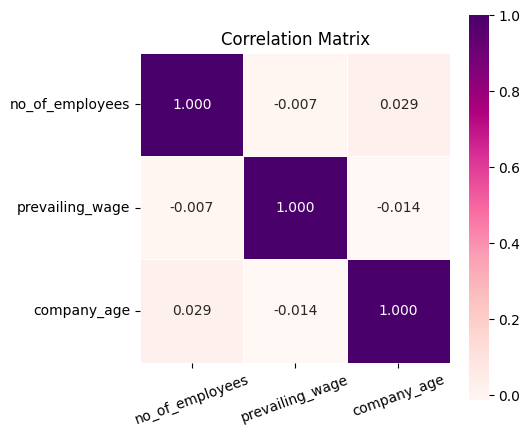

In [69]:
# Compute and plot the correlation coefficient between every pair of features
corr_matrix = df_train[numerical].corr()
plt.figure(figsize=(5, 5))

# Plot the heatmap for correlation matrix
cm = sns.heatmap(corr_matrix, annot=True, cmap='RdPu', fmt='.3f', linewidths=0.5, square=True)
plt.title('Correlation Matrix')
plt.xticks(rotation=20)
plt.yticks(rotation=0)

plt.show()

**Insights:**
- The correlation matrix reveals minimal linear relationships between the numerical features (`no_of_employees`, `prevailing_wage`, and `company_age`). The correlation coefficients are close to zero. 
- The low correlations suggest that these features are relatively independent of each other. 
- This lack of strong correlation indicates that multicollinearity is unlikely to be a major concern in this dataset. 
- Given the low correlations, creating interaction terms between these features may not substantially improve model performance. However, further analysis and experimentation are needed to confirm this.

### Feature Transformation

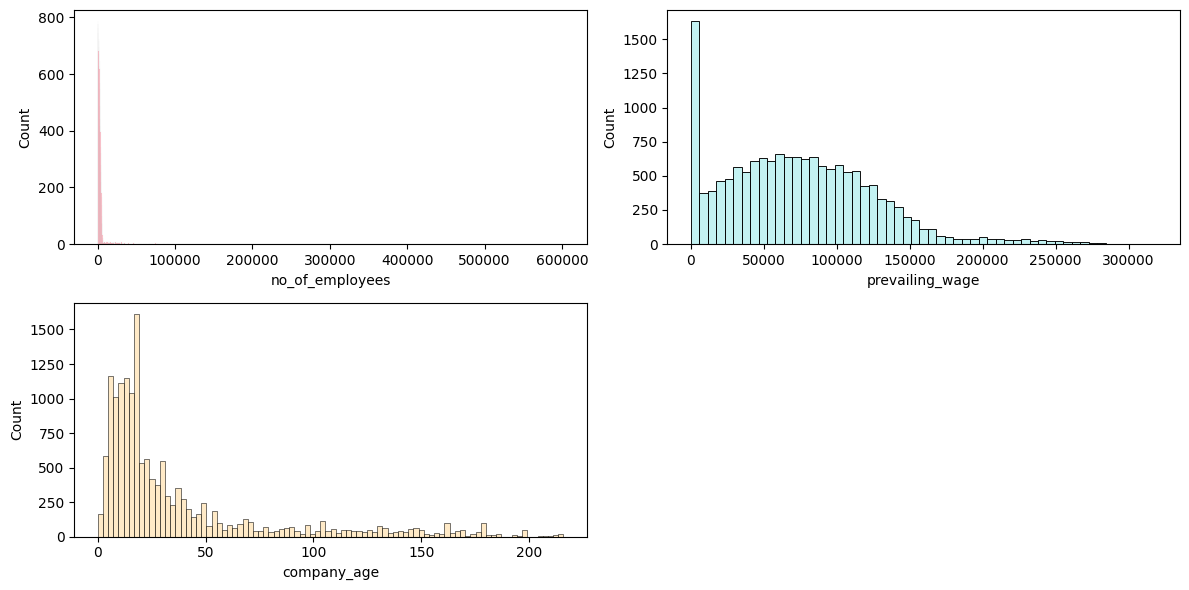

In [70]:
# Plot distribution of numerical features before scaling
plt.figure(figsize=(12, 6))

colors = ['lightpink', 'paleturquoise', 'moccasin']

for i, feature in enumerate(numerical):
    plt.subplot(2, 2, i+1)
    # Plot the histogram
    sns.histplot(x=df_train[feature], color=colors[i])
    plt.xlabel(feature)
    plt.tight_layout()

plt.show()

In [71]:
# Check Skewness
df_train[numerical].skew(axis=0)

no_of_employees    12.853625
prevailing_wage     0.777704
company_age         2.007334
dtype: float64

Highly skewed feature distributions can negatively impact the performance of certain machine learning models. While logistic regression is more robust to non-normality than some other models, it can still be affected by skewed features. Skewed features can violate the underlying assumption of linearity between the log-odds of the outcome and the features in logistic regression. This can lead to biased predictions, especially for instances with extreme values in the skewed features, and consequently decrease model accuracy, precision, and recall.

**Insights from Skewness:**

- `no_of_employees`: The skewness value of 12.85 indicates a highly right-skewed distribution. This means the data is concentrated towards the lower end (fewer employees) with a long tail towards the higher end (a few companies with a very large number of employees).

- `prevailing_wage`: A skewness value of 0.777 suggests a moderate right-skewed distribution. This means the data is slightly concentrated towards the lower wages with a longer tail towards the higher wages.

- `company_age`: The skewness value of 2.007 indicates a right-skewed distribution. This means the data is concentrated towards younger companies with a longer tail towards older companies.

#### Experiment with Yeo-Johnson transformation

The Yeo-Johnson transformation extends the Box-Cox transformation by accommodating positive, negative, and zero values. Unlike Box-Cox, which is limited to strictly positive values, Yeo-Johnson offers greater flexibility: It effectively handles both right-skewed and left-skewed distributions.

In [72]:
from sklearn.preprocessing import PowerTransformer

In [73]:
transform_features = ['no_of_employees', 'company_age']

pt = PowerTransformer(method='yeo-johnson')
X_train_transformed = pt.fit_transform(df_train[transform_features])

In [74]:
df_transformed = pd.DataFrame(X_train_transformed, columns=transform_features)

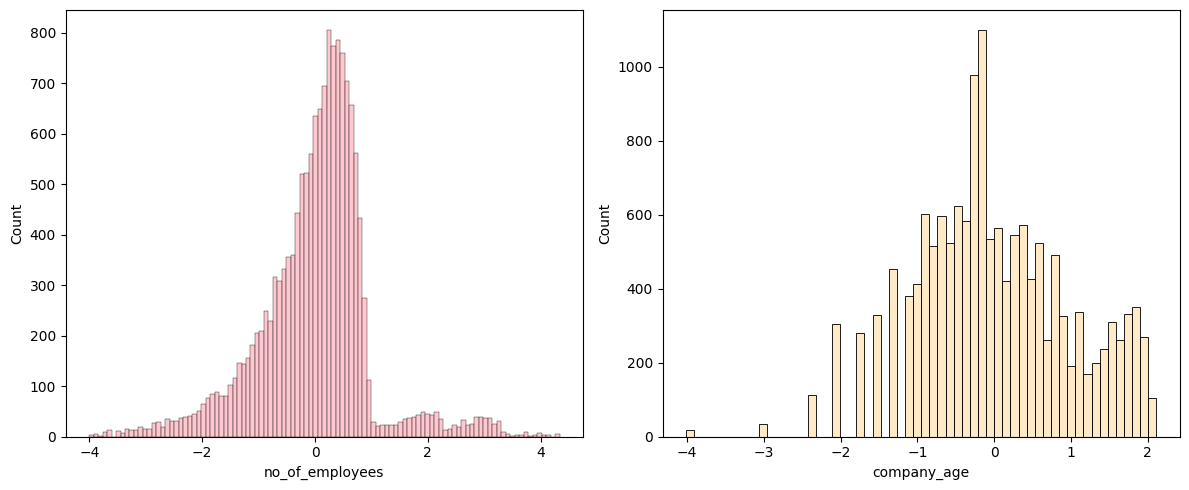

In [75]:
# Plot distribution of numerical features after scaling
plt.figure(figsize=(12, 5))

colors = ['lightpink', 'moccasin']

for i, feature in enumerate(transform_features):
    plt.subplot(1, 2, i+1)
    # Plot the histogram
    sns.histplot(x=df_transformed[feature], color=colors[i])
    plt.xlabel(feature)
    plt.tight_layout()

plt.show()

In [76]:
# Check Skewness
df_transformed.skew(axis=0)

no_of_employees   -0.023475
company_age        0.009601
dtype: float64

**Insights:**
- The Yeo-Johnson transformation effectively reduced the skewness in the two numerical features (`no_of_employees` and `company_age`). This is evident from the significantly lower skewness values after the transformation.

- By mitigating skewness, the Yeo-Johnson transformation has the potential to improve the performance of models sensitive to non-normality. This is because the transformation brings the data distribution closer to normality, which can enhance model accuracy and predictive power.

- It's crucial to remember that after the Yeo-Johnson transformation, the original interpretation of the features changes. The units of `no_of_employees` and `company_age` are no longer directly interpretable as they were before the transformation.

**Possible Next Steps:**
- Train machine learning models (e.g., logistic regression, random forest) on both the transformed and original data. Evaluate their performance using appropriate metrics (e.g., accuracy, precision, recall, F1-score, AUC) to assess the impact of the Yeo-Johnson transformation on model accuracy and identify the approach that yields the best results.

- Experiment with other data transformations, such as the Box-Cox transformation or quantile transformations, to further investigate their impact on model performance and feature interpretability.

- Explore the use of robust models that are less sensitive to non-normality, such as tree-based models (e.g., Random Forest, Gradient Boosting Machines). 

#### Encode binary categorical features

In [77]:
# Encode binary categorical features using binary encoding (0 for "N", 1 for "Y")
df_train.has_job_experience = (df_train.has_job_experience == 'Y').astype(int)
df_val.has_job_experience = (df_val.has_job_experience == 'Y').astype(int)

df_train.full_time_position = (df_train.full_time_position == 'Y').astype(int)
df_val.full_time_position = (df_val.full_time_position == 'Y').astype(int)

df_train.requires_job_training = (df_train.requires_job_training == 'Y').astype(int)
df_val.requires_job_training = (df_val.requires_job_training == 'Y').astype(int)

In [78]:
df_train.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,company_age
0,Asia,Bachelor's,0,0,2500,Northeast,105.87,Hour,1,45
1,Asia,Bachelor's,0,0,1527,South,38764.07,Year,1,3
2,Asia,Master's,0,0,5380,West,37037.67,Year,1,18
3,Asia,Bachelor's,1,0,3035,West,89891.32,Year,0,109
4,Asia,Master's,0,0,546,South,149133.36,Year,1,2


#### Feature scaling

In [79]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [80]:
# Create ColumnTransformer with 2 types of transformers
oh_columns = ['continent', 'unit_of_wage', 'region_of_employment', 'education_of_employee']
transform_columns= ['no_of_employees', 'company_age']

oh_transformer = OneHotEncoder()

transform_pipeline = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

# Transform data to have a mean of 0 and a standard deviation of 1
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder', oh_transformer, oh_columns),
        ('Transformer', transform_pipeline, transform_columns),
        ('StandardScaler', numeric_transformer, numerical)
    ], remainder='passthrough'
)

In [81]:
X_train = preprocessor.fit_transform(df_train)
X_train[0]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.24627662,
        0.74036002, -0.13674828, -1.40813909,  0.19025859,  0.        ,
        0.        ,  1.        ])

In [82]:
X_train.shape

(15261, 27)

In [83]:
preprocessor.get_feature_names_out()

array(['OneHotEncoder__continent_Africa', 'OneHotEncoder__continent_Asia',
       'OneHotEncoder__continent_Europe',
       'OneHotEncoder__continent_North America',
       'OneHotEncoder__continent_Oceania',
       'OneHotEncoder__continent_South America',
       'OneHotEncoder__unit_of_wage_Hour',
       'OneHotEncoder__unit_of_wage_Month',
       'OneHotEncoder__unit_of_wage_Week',
       'OneHotEncoder__unit_of_wage_Year',
       'OneHotEncoder__region_of_employment_Island',
       'OneHotEncoder__region_of_employment_Midwest',
       'OneHotEncoder__region_of_employment_Northeast',
       'OneHotEncoder__region_of_employment_South',
       'OneHotEncoder__region_of_employment_West',
       "OneHotEncoder__education_of_employee_Bachelor's",
       'OneHotEncoder__education_of_employee_Doctorate',
       'OneHotEncoder__education_of_employee_High School',
       "OneHotEncoder__education_of_employee_Master's",
       'Transformer__no_of_employees', 'Transformer__company_age',
      

In [84]:
df_train.head(1)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,company_age
0,Asia,Bachelor's,0,0,2500,Northeast,105.87,Hour,1,45


In [85]:
X_val = preprocessor.transform(df_val)
X_val[0]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        , -0.69254934,
        1.70137852, -0.21065584, -0.48190652,  2.21141788,  0.        ,
        0.        ,  1.        ])

In [86]:
X_val.shape

(5087, 27)

## 5. Data Modeling

### Model evaluation and metrics

In [87]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, precision_score, 
                            recall_score, f1_score, roc_auc_score, average_precision_score)
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [88]:
def evaluate_clf(y, y_pred):
    acc = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auroc = roc_auc_score(y, y_pred)
    auprc = average_precision_score(y, y_pred)
    return acc, precision, recall, f1, auroc, auprc

In [89]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(),
    'K-Neighbors Classifier': KNeighborsClassifier(),
    'XGBClassifier': XGBClassifier(random_state=42), 
    'CatBoosting Classifier': CatBoostClassifier(random_state=42, verbose=False),
    'Support Vector Classifier': SVC(),
    'AdaBoost Classifier': AdaBoostClassifier(random_state=42)
}

In [90]:
# Evaluate a dictionary of models and return a report 
def evaluate_models(X_train, y_train, X_val, y_val, models):
    train_results = []
    val_results = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Train set performance
        (train_acc, train_precision, train_recall,
        train_f1, train_auroc, train_auprc) = evaluate_clf(y_train ,y_train_pred)

        # Validation set performance
        (val_acc, val_precision, val_recall,
        val_f1, val_auroc, val_auprc) = evaluate_clf(y_val, y_val_pred)

        # Model performance on Training set
        train_result = {
            'Model Name': list(models.keys())[i],
            'Accuracy': train_acc,
            'Precision': train_precision,
            'Recall': train_recall,
            'F1-score': train_f1,
            'AUROC': train_auroc,
            'AUPRC': train_auprc
        }
        train_results.append(train_result)

        # Model performance on Validation set
        val_result = {
            'Model Name': list(models.keys())[i],
            'Accuracy': val_acc,
            'Precision': val_precision,
            'Recall': val_recall,
            'F1-score': val_f1,
            'AUROC': val_auroc,
            'AUPRC': val_auprc
        }
        val_results.append(val_result)

    df_train_report = pd.DataFrame(train_results).sort_values(by=['Accuracy'], ascending=False)
    df_val_report = pd.DataFrame(val_results).sort_values(by=['Accuracy'], ascending=False)
    return df_train_report, df_val_report

In [91]:
Counter(y_train)

Counter({1: 10235, 0: 5026})

The train set exhibits a class imbalance, with approximately twice as many certified applications as denied applications.

In [92]:
train_perf_report, val_perf_report = evaluate_models(X_train=X_train, y_train=y_train,
                                                     X_val=X_val, y_val=y_val, models=models)

##### Check model performance on train set

In [93]:
train_perf_report

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
0,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,XGBClassifier,0.850993,0.853539,0.938935,0.894203,0.805421,0.842372
6,CatBoosting Classifier,0.798572,0.812680,0.909233,0.858250,0.741226,0.799790
4,K-Neighbors Classifier,0.793985,0.817954,0.891158,0.852988,0.743629,0.801922
2,Gradient Boosting,0.758797,0.784659,0.882560,0.830735,0.694662,0.771272
7,Support Vector Classifier,0.753751,0.773314,0.895261,0.829832,0.680420,0.762563
3,Logistic Regression,0.740908,0.767801,0.879726,0.819962,0.668972,0.756118
8,AdaBoost Classifier,0.740581,0.763123,0.889204,0.821353,0.663563,0.752878


##### Check model performance on validation set

In [94]:
val_perf_report

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
2,Gradient Boosting,0.748575,0.776061,0.874815,0.822484,0.685937,0.762260
6,CatBoosting Classifier,0.746216,0.774633,0.872749,0.820769,0.683433,0.760786
7,Support Vector Classifier,0.742481,0.764048,0.887216,0.821038,0.670667,0.752969
3,Logistic Regression,0.735601,0.761795,0.877177,0.815425,0.665353,0.750006
8,AdaBoost Classifier,0.730686,0.753583,0.884854,0.813960,0.654192,0.743477
5,XGBClassifier,0.730489,0.765543,0.857986,0.809133,0.667229,0.751380
0,Random Forest,0.725772,0.767598,0.843519,0.803770,0.667348,0.751671
4,K-Neighbors Classifier,0.707686,0.753469,0.833776,0.791591,0.645123,0.738898
1,Decision Tree,0.652841,0.739864,0.738116,0.738989,0.610529,0.720472


#### Hyperparameter Tuning

Based on the initial model evaluation, **Gradient Boosting**, **CatBoosting Classifier**, and **Support Vector Classifier** emerged as the top-3 performing models. We will now proceed with hyperparameter tuning for these models to potentially enhance their predictive accuracy. 

In [ ]:
# Initialize parameters for Hyperparameter Tuning
gb_params = {
    'n_estimators': [8, 16, 32, 64, 128, 256],
    'learning_rate': [0.1, 0.01, 0.05, 0.001],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'min_samples_leaf': [1, 3, 5, 10, 25, 50]
    'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]
}

cb_params = {
    'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
    'depth': [3, 4, 5, 6, 8, 10],
    'iterations': [30, 50, 100, 300, 500]
}

sv_params = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf']
}

#### Experiment with SMOTE

In [96]:
from imblearn.over_sampling import SMOTE

In [97]:
smt = SMOTE(random_state=42)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

In [98]:
Counter(y_train_sm)

Counter({1: 10235, 0: 10235})

In [99]:
train_perf_report_sm, val_perf_report_sm = evaluate_models(X_train=X_train_sm, y_train=y_train_sm,
                                                           X_val=X_val, y_val=y_val, models=models)

##### Check model performance on train set

In [104]:
train_perf_report_sm

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
0,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,XGBClassifier,0.865657,0.852501,0.884319,0.868118,0.865657,0.811723
4,K-Neighbors Classifier,0.836346,0.889908,0.767660,0.824276,0.836346,0.799317
6,CatBoosting Classifier,0.835125,0.814390,0.868100,0.840388,0.835125,0.772922
2,Gradient Boosting,0.761602,0.757675,0.769223,0.763405,0.761602,0.698210
7,Support Vector Classifier,0.733317,0.715640,0.774304,0.743817,0.733317,0.666971
8,AdaBoost Classifier,0.720616,0.719992,0.722032,0.721011,0.720616,0.658841
3,Logistic Regression,0.704543,0.702407,0.709819,0.706094,0.704543,0.643673


##### Check model performance on validation set

In [105]:
val_perf_report_sm

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
6,CatBoosting Classifier,0.742677,0.791526,0.832890,0.811682,0.697916,0.770519
2,Gradient Boosting,0.725182,0.815414,0.759079,0.786239,0.708363,0.779372
0,Random Forest,0.723019,0.794872,0.787127,0.790981,0.691211,0.767399
7,Support Vector Classifier,0.720661,0.809314,0.759374,0.783549,0.701452,0.774784
5,XGBClassifier,0.719678,0.784450,0.798347,0.791337,0.680644,0.760527
3,Logistic Regression,0.698840,0.815155,0.708296,0.757978,0.694148,0.771592
8,AdaBoost Classifier,0.695105,0.807641,0.711544,0.756553,0.686949,0.766730
4,K-Neighbors Classifier,0.665618,0.791494,0.675819,0.729097,0.660557,0.750751
1,Decision Tree,0.651071,0.751404,0.711249,0.730775,0.621213,0.726690


#### Experiment with ADASYN

In [106]:
from imblearn.over_sampling import ADASYN

In [107]:
ada = ADASYN(random_state=42)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

In [108]:
Counter(y_train_ada)

Counter({0: 10390, 1: 10235})

In [109]:
train_perf_report_ada, val_perf_report_ada = evaluate_models(X_train=X_train_ada, y_train=y_train_ada,
                                                              X_val=X_val, y_val=y_val, models=models)

##### Check model performance on train set

In [110]:
train_perf_report_ada

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
1,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0,Random Forest,0.999952,1.000000,0.999902,0.999951,0.999951,0.999951
5,XGBClassifier,0.862739,0.848785,0.880215,0.864214,0.862870,0.806555
4,K-Neighbors Classifier,0.835782,0.935070,0.719003,0.812925,0.834911,0.811761
6,CatBoosting Classifier,0.831224,0.809476,0.863019,0.835390,0.831461,0.766569
2,Gradient Boosting,0.736388,0.743702,0.715291,0.729220,0.736231,0.673248
7,Support Vector Classifier,0.704048,0.739146,0.623742,0.676558,0.703449,0.647751
8,AdaBoost Classifier,0.688727,0.688544,0.680606,0.684552,0.688667,0.627124
3,Logistic Regression,0.664970,0.666834,0.649243,0.657921,0.664852,0.606998


##### Check model performance on validation set

In [111]:
val_perf_report_ada

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
6,CatBoosting Classifier,0.739729,0.792957,0.824328,0.808338,0.697752,0.770621
5,XGBClassifier,0.724985,0.793388,0.793623,0.793506,0.690929,0.767060
0,Random Forest,0.709259,0.793178,0.762031,0.777293,0.683074,0.762869
2,Gradient Boosting,0.702968,0.825017,0.702982,0.759126,0.702962,0.777731
8,AdaBoost Classifier,0.682917,0.816334,0.675819,0.739461,0.686439,0.767538
3,Logistic Regression,0.679575,0.830636,0.651609,0.730311,0.693452,0.773214
7,Support Vector Classifier,0.663456,0.845931,0.604665,0.705234,0.692627,0.774725
1,Decision Tree,0.640849,0.741935,0.706230,0.723642,0.608409,0.719573
4,K-Neighbors Classifier,0.634952,0.792431,0.612046,0.690655,0.646317,0.743310


#### Experiment with SMOTETomek

In [112]:
from imblearn.combine import SMOTETomek

In [113]:
smtom = SMOTETomek(random_state=42)
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, y_train)

In [114]:
Counter(y_train_smtom)

Counter({0: 9458, 1: 9458})

In [115]:
train_perf_report_smtom, val_perf_report_smtom = evaluate_models(X_train=X_train_smtom, y_train=y_train_smtom,
                                                                 X_val=X_val, y_val=y_val, models=models)

##### Check model performance on train set

In [116]:
train_perf_report_smtom

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
0,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,XGBClassifier,0.884912,0.875193,0.897864,0.886384,0.884912,0.836873
4,K-Neighbors Classifier,0.856048,0.909622,0.790653,0.845975,0.856048,0.823869
6,CatBoosting Classifier,0.853087,0.836881,0.877141,0.856538,0.853087,0.795492
2,Gradient Boosting,0.781349,0.775295,0.792345,0.783727,0.781349,0.718129
7,Support Vector Classifier,0.752538,0.734052,0.792028,0.761939,0.752538,0.685376
8,AdaBoost Classifier,0.737471,0.729652,0.754494,0.741865,0.737471,0.673271
3,Logistic Regression,0.721664,0.719139,0.727427,0.723259,0.721664,0.659407


##### Check model performance on validation set

In [117]:
val_perf_report_smtom

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
6,CatBoosting Classifier,0.741301,0.793260,0.826986,0.809772,0.698787,0.771210
2,Gradient Boosting,0.730883,0.816897,0.767936,0.791660,0.712498,0.781836
5,XGBClassifier,0.725378,0.789412,0.801299,0.795311,0.687708,0.764853
7,Support Vector Classifier,0.720857,0.809569,0.759374,0.783668,0.701746,0.774978
0,Random Forest,0.720267,0.791222,0.787718,0.789466,0.686800,0.764600
8,AdaBoost Classifier,0.703755,0.807793,0.728373,0.766030,0.691540,0.769228
3,Logistic Regression,0.699626,0.816049,0.708592,0.758534,0.695178,0.772269
4,K-Neighbors Classifier,0.671122,0.796951,0.679067,0.733301,0.667181,0.754865
1,Decision Tree,0.659524,0.753446,0.726306,0.739627,0.626389,0.729462


#### Experiment with SMOTEENN

In [118]:
from imblearn.combine import SMOTEENN

In [119]:
smte = SMOTEENN(random_state=42)
X_train_smte, y_train_smte = smte.fit_resample(X_train, y_train)

In [120]:
Counter(y_train_smte)

Counter({0: 5710, 1: 4802})

In [121]:
train_perf_report_smte, val_perf_report_smte = evaluate_models(X_train=X_train_smte, y_train=y_train_smte,
                                                               X_val=X_val, y_val=y_val, models=models)

##### Check model performance on train set

In [122]:
train_perf_report_smte

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
0,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,XGBClassifier,0.985350,0.983965,0.983965,0.983965,0.985240,0.975512
4,K-Neighbors Classifier,0.974505,0.979687,0.964182,0.971872,0.973684,0.960958
6,CatBoosting Classifier,0.962424,0.953675,0.964598,0.959105,0.962597,0.936085
7,Support Vector Classifier,0.907249,0.884160,0.917118,0.900337,0.908034,0.848740
2,Gradient Boosting,0.899068,0.882125,0.899209,0.890585,0.899079,0.839257
8,AdaBoost Classifier,0.868817,0.853835,0.860058,0.856935,0.868120,0.798275
3,Logistic Regression,0.867009,0.848057,0.863599,0.855757,0.866738,0.794691


##### Check model performance on validation set

In [123]:
val_perf_report_smte

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
6,CatBoosting Classifier,0.711225,0.827080,0.715973,0.767527,0.708869,0.781277
0,Random Forest,0.707883,0.830149,0.705639,0.762847,0.708996,0.781776
5,XGBClassifier,0.706900,0.818121,0.719811,0.765824,0.700494,0.775446
2,Gradient Boosting,0.697661,0.836304,0.678772,0.749348,0.707033,0.781538
7,Support Vector Classifier,0.696678,0.829993,0.684677,0.750364,0.702632,0.778224
3,Logistic Regression,0.687045,0.837026,0.658105,0.736860,0.701405,0.778490
1,Decision Tree,0.684686,0.821261,0.672867,0.739695,0.690551,0.770410
8,AdaBoost Classifier,0.682328,0.830287,0.657219,0.733685,0.694786,0.773909
4,K-Neighbors Classifier,0.670926,0.823330,0.643933,0.722664,0.684319,0.767244
